# CO2 Emissions. Machine Learning - Regression models

Part 2: Machine Learning - Regression models solves the problem of predicting the pollution emitted by vehicles based on different vehicle measurements, such as highway fuel consumption, city fuel consumption, engine size, or the number of gears, among others. This notebook uses the preprocessed dataset created as output of the first part of the portofolio. Specifically, it has 6,281 rows, 7 features and 1 response variable to be predicted.

- **Dataset Reference**: Debajyoti Podder (2020). Dataset: CO2 Emission by Vehicles - Amount of CO2 emissions by a vehicle depending on their various features. URL: [https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles](https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles)

## Setup: Importing Packages and Defining Utility Functions
The following cells import the required packages and defines functions to enhance code readability and prevent duplication.

In [ ]:
# Kagglehub is used to directly download the data file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Machine Learning regression models and measurements
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from xgboost.sklearn import XGBRegressor

# Display options
pd.options.display.float_format = "{:,.4f}".format

In [ ]:
# Functions used to pre-process the data as done within the first notebook
def add_gears_trans(df_raw):
  """
  Function to add the features gears and transmission to the dataset.

  Parameters:
    df_raw (pandas dataframe): raw dataset.

  Returns:
    pd.DataFrame: Modified dataset with added 'Gears' and updated 'Transmission' columns.
  """
  gears = df_raw["Transmission"].str[-1]; transmission = df_raw["Transmission"].str[:-1]

  # We need to correct the values for the AV category and cars with 10 gears (A10, AV10, AS10).
  transmission[gears == "0"] = transmission[gears == "0"].str[:-1]
  transmission[gears == "V"] = transmission[gears == "V"] + "V"
  gears[gears == "0"] = 10; gears[gears == "V"] = 0 # Remove extra 1s and add a V

  df_raw["Gears"] = gears.astype(int); df_raw["Transmission"] = transmission
  return df_raw

def process_data(df_raw):
  """
  Function to pre-process the data as done in the first notebook, including
  droping certain observations and variables, adding the new features,
  feature normalization and recoding the categorical variables to numerical values.

  Parameters:
    df_raw (pd.DataFrame): Raw dataset.

  Returns:
    pd.DataFrame: Processed dataset with normalized and encoded features.
  """
  drop_vars=["Fuel Consumption Comb (mpg)", "Fuel Consumption Comb (L/100 km)",
             "Make", "Model", "Vehicle Class"]
  num_vars = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
              "Engine Size(L)", "Cylinders", "Gears"]

  # Removal of certain observations and variables. Identification of rows
  remove_obs_cond = (df_raw.duplicated()) | (df_raw["Fuel Type"]=="N")
  df_processed = add_gears_trans(df_raw.copy()).loc[~remove_obs_cond,]
  df_processed.index = df_processed["Make"]+" - "+df_processed["Model"]
  df_processed = df_processed.drop(columns=drop_vars)

  # Feature normalization and recoding the categorical variables to numerical values
  cars_df_nums = df_processed[num_vars]
  df_processed[num_vars] = pd.DataFrame(StandardScaler().fit_transform(cars_df_nums),
                                        columns=cars_df_nums.columns, index=cars_df_nums.index)
  df_processed[["Transmission","Fuel Type"]] = OrdinalEncoder().fit_transform(
      df_processed[["Transmission","Fuel Type"]])
  return df_processed

# Functions used to measure the performance of the ML models
def get_error_measurements(train_set, test_set, fitted_model, print_results=True):
  """
  Get the R2 and MSE of the fitted models in the training and test set

  Parameters:
    train_set (list: features, response): Train data list (features X, response y).
    test_set (list: features, response): Test data list (features X, response y).
    fitted_model (scikit-learn or statsmodel fitted model): Model fitted to train data.
    print_results (bool): Should results be printed on screen?

  Returns:
    pd.DataFrame: DataFrame containing R2 and MSE for training and test sets.
  """
  train_X, train_y = train_set; test_X, test_y = test_set
  train_pred = fitted_model.predict(train_X)
  test_pred = fitted_model.predict(test_X)

  acc_train = r2_score(train_y, train_pred)
  acc_test = r2_score(test_y, test_pred)
  mse_train = mean_squared_error(train_y, train_pred)
  mse_test = mean_squared_error(test_y, test_pred)

  if print_results:
    print(f"R2 :\tTrain = {acc_train:.4f} \t\t Test = {acc_test:.4f}")
    print(f"MSE:\tTrain = {mse_train:.4f} \t Test = {mse_test:.4f}")
  return pd.DataFrame({"Train-R2": [acc_train],  "Test-R2": [acc_test],
                       "Train-MSE": [mse_train], "Test-MSE": [mse_test]})

# Functions using in the hyperparameter tuning process
def hyper_param_tuning(model, param_grid, train_set, print_result=True):
    """
    Performs hyperparameter tuning using GridSearchCV to optimize model performance.

    Parameters:
      model (estimator object): The machine learning model to be tuned. Expected to be a scikit-learn estimator.
      param_grid (dict): Dictionary containing hyperparameter names and their possible values.
      train_set (tuple): Tuple containing training features and target (train_X, train_y).
      print_result (bool): Whether to print the best hyperparameters found. Default is True.

    Returns:
      dict: The best hyperparameter combination based on the highest R2 score.
    """
    train_X, train_y = train_set

    # Initializes GridSearchCV with the model, parameter grid, R2 scoring, and 5-fold cross-validation
    gsearch = GridSearchCV(param_grid=param_grid, scoring='r2', cv=5, estimator=model)

    # Fits GridSearchCV to the training data to evaluate all parameter combinations
    gsearch.fit(train_X, train_y)

    # Print (if needed) and returns the best hyperparameter combination based on the highest R2 score
    if print_result:
        print("Best hyper parameter configuration: "+str(gsearch.best_params_))
    return gsearch.best_params_

# Plotting functions
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    """
    Plots predicted values against actual values in a regression problem.

    Parameters:
      y_true (number array): Actual values.
      y_pred (number array): Predicted values.
      title (str): Title of the plot.

    Returns:
      None: Displays the scatter plot of predicted vs actual values.
    """
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Identity (y=x)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title, loc="left")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

def plot_residuals(y_true, y_pred, title="Residuals Plot"):
    """
    Plots residuals (errors) of predicted vs actual values in a regression problem.

    Parameters:
      y_true (number array): Actual values.
      y_pred (number array): Predicted values.
      title (str): Title of the plot.

    Returns:
      None: Displays the scatter plot of residuals.
    """
    residuals = np.array(y_true) - np.array(y_pred)
    plt.scatter(range(len(residuals)), residuals, alpha=0.5, color='green', label='Residuals')
    plt.axhline(y=0, color='orange', linestyle='--', label='Zero Error Line')
    plt.ylim(-300, 300) # Common axis limits for easier comparisons
    plt.xlabel('Index')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title(title, loc="left")
    plt.legend()
    plt.grid(True)

def plot_regression_diagnostics(y_true, y_pred, title_pred_vs_act="Predicted vs Actual",
                               title_residuals="Residuals Plot", fig_title="Regression Diagnostics"):
    """
    Creates a figure with two subplots: Predicted vs Actual and Residuals.

    Parameters:
      y_true (number array): Actual values.
      y_pred (number array): Predicted values.
      title_pred_vs_act (str): Title for predicted vs actual subplot.
      title_residuals (str): Title for residuals subplot.
      fig_title (str): Overall figure title.

    Returns:
      None: Displays the figure with regression diagnostics.
    """
    plt.figure(figsize=(12, 5))

    # Subplot 1: Predicted vs Actual
    plt.subplot(1, 2, 1)
    plot_predicted_vs_actual(y_true, y_pred, title=title_pred_vs_act)

    # Subplot 2: Residuals
    plt.subplot(1, 2, 2)
    plot_residuals(y_true, y_pred, title=title_residuals)

    # Overall figure title
    plt.suptitle(fig_title, fontsize=16, x=0.2)
    plt.tight_layout(rect=[0, 0, 1, 0.975])  # Adjust layout to fit suptitle
    plt.show()

def plot_reg_results(ml_results, data_is_long=True):
    """
    Plot machine learning model performance results with R² as bars and MSE as a line.
    Highlights the best mark (highest R², lowest MSE) with a star.
    Uses a single common legend and disables x-axis grid lines.

    Parameters:
        ml_results: DataFrame containing model performance metrics
        data_is_long: boolean indicating if data is in long format (default: True)

    Returns:
        None: Displays the plot with ML results.
    """
    # Convert wide-format data to long format if necessary using melt
    if not data_is_long:
        ml_results = pd.melt(ml_results, id_vars=["Model", "Features"], var_name="Metric",
                             value_vars=["Test R2", "Test MSE"], value_name="Value")

    # Create a combined column for y-axis labels with Model and Features
    ml_results['Model_Feature'] = ml_results['Model'] + "\n(Features =" + ml_results['Features'] + ")"

    # Find the maximum value for R² and minimum for MSE
    max_r2 = ml_results[ml_results['Metric'] == 'Test R2']['Value'].max()
    min_mse = ml_results[ml_results['Metric'] == 'Test MSE']['Value'].min()

    # Set seaborn style and create figure with two y-axes
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax2 = ax1.twinx()  # Secondary y-axis for MSE

    # Create bar plot for Test R2
    r2_data = ml_results[ml_results['Metric'] == 'Test R2']
    bar_plot = sns.barplot(data=r2_data, y='Value', x='Model_Feature', color="#5EA5C5",
                           alpha=1, ax=ax1, label="Test R2", legend=False)

    # Create line plot for Test MSE
    mse_data = ml_results[ml_results['Metric'] == 'Test MSE']
    sns.lineplot(data=mse_data, y='Value', x='Model_Feature', color="#EE854A",
                 marker='o', linewidth=2, ax=ax2, label="Test MSE", legend=False)

    # Set axis limits and ticks to align grid lines
    ax1.set_ylim(0, 1.1)  # R2 range
    mse_max = mse_data['Value'].max() * 1.1  # Dynamic MSE range
    ax2.set_ylim(0, mse_max)

    # Set consistent number of ticks (e.g., 6) for both axes to align grid lines
    n_ticks = 6
    ax1.set_yticks(np.linspace(0, 1.1, n_ticks))
    ax2.set_yticks(np.linspace(0, mse_max, n_ticks))

    # Set axis labels and customize ticks
    ax1.set_ylabel("Test R-Squared", fontsize=12)
    ax2.set_ylabel("Test MSE", fontsize=12)
    ax1.set_xlabel("")
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)

    # Enable y-axis grid lines only for ax1 to avoid clutter
    ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)
    ax2.grid(False)  # Disable ax2 grid to avoid overlap

    # Set title
    ax1.set_title("Model Performance: R-Squared (Bars) and MSE (Line) in the Test dataset", fontsize=14,
                  loc='left', weight='bold', pad=20)

    # Create a common legend for both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left',
               frameon=True, title="Metric", title_fontsize='12', fontsize='10')

    # Add value labels to bars (R2) and points (MSE)
    for i, p in enumerate(bar_plot.patches):
        height = p.get_height()
        if height > 0:
            label = f'{height:.3f}'
            if abs(height - max_r2) < 1e-6:
                label += '*'  # Star for best R2
            ax1.text(p.get_x() + p.get_width() / 2, height + 0.02,
                     label, ha='center', va='bottom', fontsize=9,
                     weight='bold' if '*' in label else 'normal',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4') if '*' in label else None)

    for i, (x, y) in enumerate(zip(mse_data['Model_Feature'], mse_data['Value'])):
        label = f'{y:.1f}'
        if abs(y - min_mse) < 1e-6:
            label += '*'  # Star for best (lowest) MSE
        ax2.text(i, y + mse_max * 0.02, label,
                 ha='center', va='bottom', fontsize=9,
                 weight='bold' if '*' in label else 'normal',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4') if '*' in label else None)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

## Data Load
The following cell loads the dataset as a DataFrame, and pre-processes it as done within the first notebook (this includes the feature normalization and recoding the categorical variables to numerical values). Moreover, it divides the variables into predictive features (`X`) and reponse variable (`y`).

In [ ]:
datapath = kagglehub.dataset_download("debajyotipodder/co2-emission-by-vehicles", path='CO2 Emissions_Canada.csv')
df_processed = process_data(pd.read_csv(datapath, header=0, sep=',', quotechar='"'))
complete_X = df_processed.copy().loc[:, df_processed.columns.difference(["CO2 Emissions(g/km)"])]
complete_y = df_processed["CO2 Emissions(g/km)"]

df_processed

,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km),Gears
ACURA - ILX,-0.8510,-0.8768,2.0000,3.0000,-0.7627,-1.0402,196,-0.9035
ACURA - ILX,-0.5580,-0.8768,4.0000,3.0000,-0.3968,-0.6014,221,-0.3404
ACURA - ILX HYBRID,-1.2172,-0.8768,3.0000,3.0000,-1.8604,-1.4351,136,0.2227
ACURA - MDX 4WD,0.2478,0.2064,2.0000,3.0000,0.0254,0.0129,255,-0.3404
ACURA - RDX AWD,0.2478,0.2064,2.0000,3.0000,-0.1435,-0.1626,244,-0.3404
...,...,...,...,...,...,...,...,...
VOLVO - XC40 T5 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.5375,-0.6014,219,0.7858
VOLVO - XC60 T5 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.3968,-0.3381,232,0.7858
VOLVO - XC60 T6 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.2561,-0.2065,240,0.7858
VOLVO - XC90 T5 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.3968,-0.3381,232,0.7858


This is a brief overview on the variables:

**Response variable** (`CO2 Emissions(g/km)`): Combined CO2 emissions (city and highway) in grams per kilometer.

**Predictive features**:

- `Engine Size(L)` [Continuous numerical variable]: Engine size in liters.
- `Fuel Consumption City (L/100 km)` [Continuous numerical variable]: Average city fuel consumption in liters per 100 kilometers.
- `Fuel Consumption Hwy (L/100 km)` [Continuous numerical variable]: Average highway fuel consumption in liters per 100 kilometers.
- `Cylinders` [Discrete numerical variable]: Number of cylinders in the car.
- `Gears` [Discrete numerical variable]: Number of gears in the car.
- `Fuel Type` [Discrete numerical variable (og. categorical)], coded as 0 = diesel, 1 = ethanol (E85), 2 = gasoline, 3 = premium gasoline.
- `Transmission` [Discrete numerical variable (og. categorical)]: type of transmission of the car, coded as 0 = Automatic, 1 = Automated Manual, 2 = Automatic with Selective Shift, 3 = Continuously Variable, 4 = Manual.

### Divide into train and test sets
In machine learning, splitting a dataset into training and testing sets is essential for building robust, generalizable models. The training set enables the model to learn data patterns, while the testing set provides an independent evaluation of its performance on unseen data. This separation prevents overfitting, ensuring the model’s reliability in real-world applications.

For simple machine learning models, hyperparameter tuning and a separate validation set may be unnecessary. A train-test split alone suffices to evaluate performance, as these models are less prone to overfitting. This approach streamlines the process and optimizes data use for training and testing.

The dataset is split into 2/3 training and 1/3 testing, with a fixed random seed for reproducibility.

In [ ]:
total_n = df_processed.shape[0]
train_n = int((2/3)*total_n)

# Randomly decide the set of train observations and the test ones
np.random.seed(123) # Set seed for reproducibility
train_indexes = np.random.choice(total_n, train_n, replace=False)
test_indexes = np.setdiff1d(np.arange(total_n), train_indexes)

train_X = complete_X.iloc[train_indexes,]; train_y = complete_y.iloc[train_indexes]
test_X = complete_X.iloc[test_indexes,]; test_y = complete_y.iloc[test_indexes]
train_set = (train_X, train_y); test_set = (test_X, test_y)

print("DATASET  : "+str(total_n)+" rows -> Train: "+str(train_n)+", Test: "+str(total_n-train_n))
print("VARIABLES: "+str(train_X.shape[1])+" features, 1 response variable.")

DATASET  : 6281 rows -> Train: 4187, Test: 2094
VARIABLES: 7 features, 1 response variable.


## Machine Learning models: Training & results
In this section, different ML models will be fitted with the training dataset. Their performances will be measured using independent data (test dataset).
The complexity of the models will go increasingly.

- The measures used for performance comparisons are:
  - $R^2$ (R-Squared): which measures the proportion of variance in the dependent variable explained by the model. Its value ranges from 0 to 1, which would mean that the model perfectly predicts the data.
  - MSE (Mean Squared Error): measures the average squared difference between predicted and actual values in a dataset. It quantifies how accurate a model's predictions are, with lower values indicating better performance.

- The implementations of the models used will be from `scikit-learn`, except the linear regression, in which case we will use the one from `statsmodels` as it directly gives the associated regression table, and the XGBoost model, from the `xgboost` package.



### Linear regression
The first used model is the linear regression, in which the relationship between the reponse variable and the set of features is suposed to be linear. Although it is enough for simple problems, in most of the cases it is used as benchmark. The fitted model is the following:

$ \hat{y} = 228.7 + 7.2$ Cylinders$ + 10.5 $ Engine Size$ + 22.2 $ Fuel C. City$ + 17.6 $ Fuel C. Hwy.$ + 9.8 $ Fuel Type$ + 2.5 $ Gears$ - 0.3 $Transmission

The atttained accuracy is fair and highlights that there is a strong linear relation between the dependent variable and the set of features. The model generalizes well, as the accuracy is the same between the two sets, meaning that it predicts well unobserved data. The value of the MSE will serve as benchmark for more complex models. The diagnostic plots indicate that the prediction error is seemingly random.


In [ ]:
print("---- LINEAR REGRESSION ----")
lr_model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
lr_model.params

---- LINEAR REGRESSION ----


,0
const,228.7389
Cylinders,7.1752
Engine Size(L),10.5109
Fuel Consumption City (L/100 km),22.1773
Fuel Consumption Hwy (L/100 km),17.5708
Fuel Type,9.8153
Gears,2.5466
Transmission,-0.3069


In [ ]:
# Accuracy measurement
train_set_constant = (sm.add_constant(train_X), train_y)
test_set_constant = (sm.add_constant(test_X), test_y)
reg_acc = get_error_measurements(train_set = train_set_constant,
                              test_set = test_set_constant, fitted_model = lr_model)

R2 :	Train = 0.8927 		 Test = 0.8918
MSE:	Train = 375.3010 	 Test = 384.3227


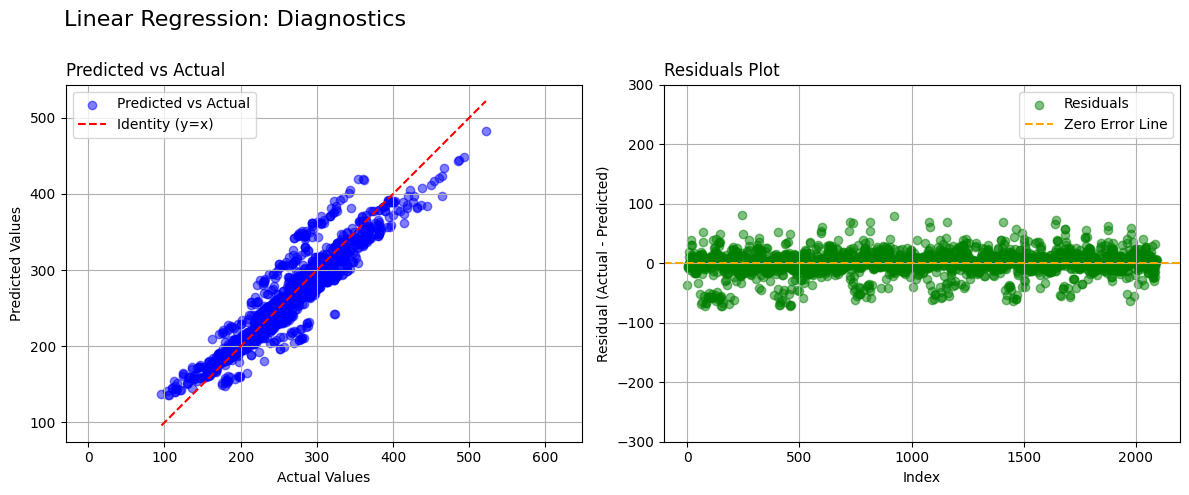

In [ ]:
plot_regression_diagnostics(test_y, lr_model.predict(test_set_constant[0]),
                            fig_title="Linear Regression: Diagnostics")

One of the strengths of the model lies in the use of statistical tests to determine the relevance of a feature within the model. The p-values of a unimportant feature takes higher values than 0.1. As seen in the table below, the `Transmission` is irrelevant to the model.

In [ ]:
# Coefficients and regression table
print(lr_model.summary().tables[1])

                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              228.7389      1.169    195.656      0.000     226.447     231.031
Cylinders                            7.1752      0.852      8.417      0.000       5.504       8.846
Engine Size(L)                      10.5109      0.895     11.745      0.000       8.756      12.265
Fuel Consumption City (L/100 km)    22.1773      1.184     18.733      0.000      19.856      24.498
Fuel Consumption Hwy (L/100 km)     17.5708      1.015     17.308      0.000      15.580      19.561
Fuel Type                            9.8153      0.482     20.373      0.000       8.871      10.760
Gears                                2.5466      0.329      7.749      0.000       1.902       3.191
Transmission                        -0.3069      0.258     -1.191      0.234      -0.812   

### LASSO regression

Although we could perform a stepwise feature selection in the regression model using the p-values, a more direct way is using a **LASSO regression** (Least Absolute Shrinkage and Selection Operator). In it, the fit is optimized using an absolute value function (instead of an squared function) which penalties the absolute values of coefficients promoting sparsity and feature selection.

Those features with smaller, unimportant coefficients are automatically eliminated from the model. Particularly, the removal of `Fuel Type` and `Transmission` does not worsen the accuracies significantly. The inclusion of this variables in the linear regression model would only add noise to the predictions. Even though the MSE values are higher, this model seems to generalize better as the MSE in the test dataset is lower. The diagnostic plots have a similar reading to the previous ones.



In [ ]:
print("---- LASSO LINEAR REGRESSION ----")
lasso_model = sm.OLS(train_y, sm.add_constant(train_X)).fit_regularized(L1_wt=1.0, zero_tol=0.5)

# Accuracy measurement
lasso_acc = get_error_measurements(train_set = train_set_constant,
                                test_set = test_set_constant, fitted_model = lasso_model)

print("\nCoefficients: ")
lasso_coeffs_names = train_X.columns.astype('string')
lasso_coeffs_names = lasso_coeffs_names.insert(0, "Inter.")
print(pd.DataFrame([lasso_model.params.tolist()], columns=lasso_coeffs_names))

---- LASSO LINEAR REGRESSION ----
R2 :	Train = 0.8818 		 Test = 0.8840
MSE:	Train = 413.4137 	 Test = 412.1526

Coefficients: 
    Inter.  Cylinders  Engine Size(L)  Fuel Consumption City (L/100 km)  \
0 251.1890    10.6760          9.3803                           22.7188   

   Fuel Consumption Hwy (L/100 km)  Fuel Type  Gears  Transmission  
0                          14.9259     0.0000 3.7247        0.0000  


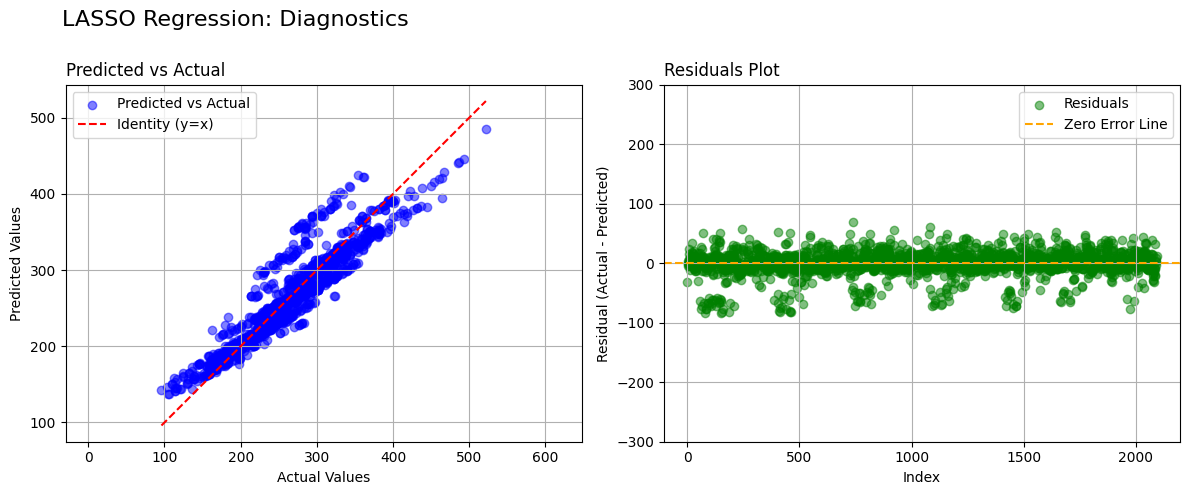

In [ ]:
plot_regression_diagnostics(test_y, lasso_model.predict(test_set_constant[0]),
                            fig_title="LASSO Regression: Diagnostics")

### Support Vector Machine (SVM)
The previous results of the linear techniques show that more complex and powerful models are needed, such as Support Vector Machines (SVM) or Regression Trees.

By finding the optimal hyperplane that best separates data points of different classes, SVM maximizes the margin between the nearest points, known as support vectors, to improve generalization. This technique relies on the assumption that data is linearly predictible in a higher-dimensional space, achieved through kernel functions. SVM's greastest strengths are its robustness, its ability to handle non-linear relationships effectively and having none or few hyperparameters (depending on the kernel). Radial basis functions are used as kernel as it is able to capture complex, non-linear relationships between features (in contrast to the linear kernel) and its tuning is simpler (in the polynomial one, the degree is an hyperparameter which must be tuned to avoid overfitting).

Both the $R^2$ and the MSE values indicate that the fitted SVM model improves the result of the linear regressions and seems to generalize well as its performance in the test dataset is even greater than in the training set. The diagnostic plots highlight that some observations are worse predicted, particularly those in the extremes of the dependent variable's range.

In [ ]:
print("---- SVM: RBF Kernel ----")
svm_model = SVR(kernel="rbf").fit(train_X, train_y)
svm_acc = get_error_measurements(train_set = train_set, test_set = test_set, fitted_model = svm_model)

---- SVM: RBF Kernel ----
R2 :	Train = 0.9048 		 Test = 0.9073
MSE:	Train = 332.9549 	 Test = 329.1070


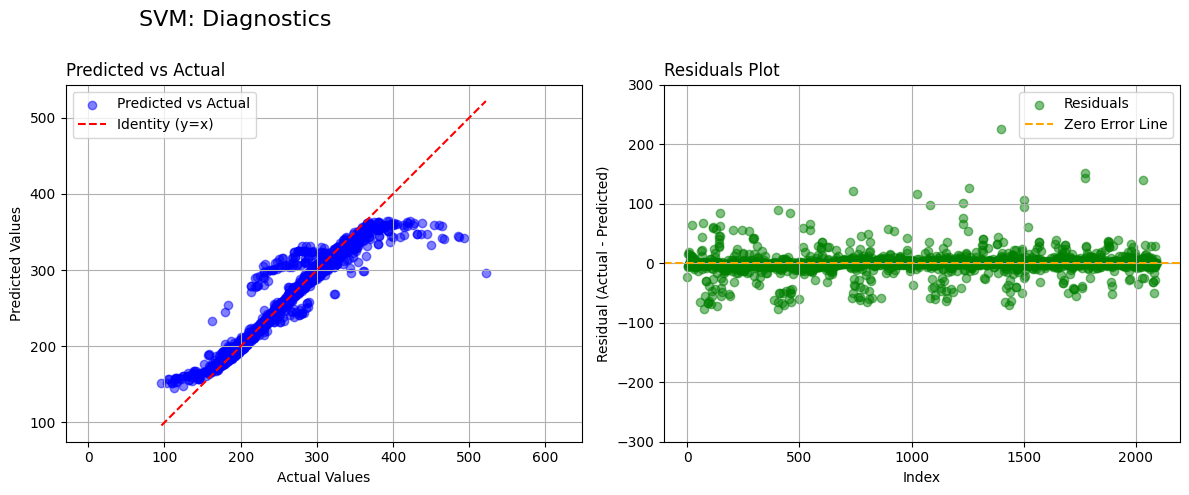

In [ ]:
plot_regression_diagnostics(test_y, svm_model.predict(test_X),
                            fig_title="SVM: Diagnostics")

### Regression Trees
Regression tree models are a type of decision tree used to predict continuous outcomes by recursively splitting the data into regions based on feature values. Each split is determined by minimizing the variance within the resulting subsets, creating a tree-like structure where terminal nodes, or leaves, represent the predicted values. This method assumes that relationships between variables can be approximated through piecewise constant functions, making it intuitive and flexible for capturing non-linear patterns. Regression trees are widely used in fields like finance and ecology for their interpretability and ability to handle complex datasets.

The fitted model achieve near perfect accuracy in both datasets, although the notable increase of the MSE in the dataset hint the existence of overfiting. The diagnostic plots remark that there are 4 observations in which the prediction differs from the actual value in more than 50. Overfitting could be mitigated with pruning or ensemble, with models like random forests or techniques such as boosting.


In [ ]:
print("---- REGRESSION TREES ----")
rt_model = DecisionTreeRegressor(criterion="absolute_error", random_state=0).fit(train_X, train_y)
rt_acc = get_error_measurements(train_set = train_set, test_set = test_set, fitted_model = rt_model)

---- REGRESSION TREES ----
R2 :	Train = 0.9996 		 Test = 0.9962
MSE:	Train = 1.3809 	 Test = 13.3340


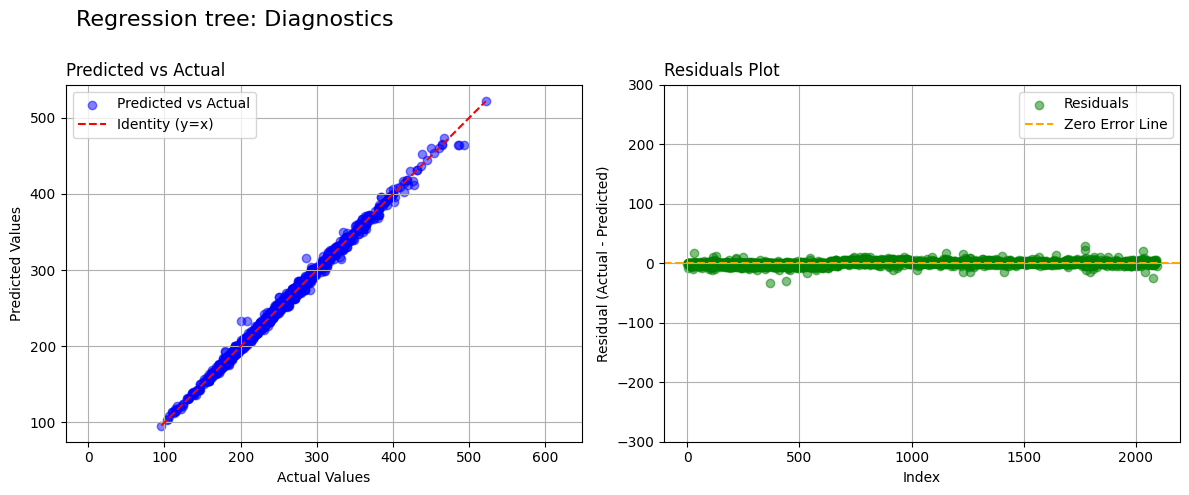

In [ ]:
plot_regression_diagnostics(test_y, rt_model.predict(test_X),
                            fig_title="Regression tree: Diagnostics")

The interpretability of tree-based models is one of their greatest strengths. The analysis highlights the relative importance of each feature and the top nodes of the model. Notably, `Fuel Consumption City (L/100 km)` emerges as the most influential variable, with `Fuel Consumption Hwy (L/100 km)` ranking second.

                                  Importance
Cylinders                             0.0016
Engine Size(L)                        0.0101
Fuel Consumption City (L/100 km)      0.8338
Fuel Consumption Hwy (L/100 km)       0.0897
Fuel Type                             0.0562
Gears                                 0.0045
Transmission                          0.0041


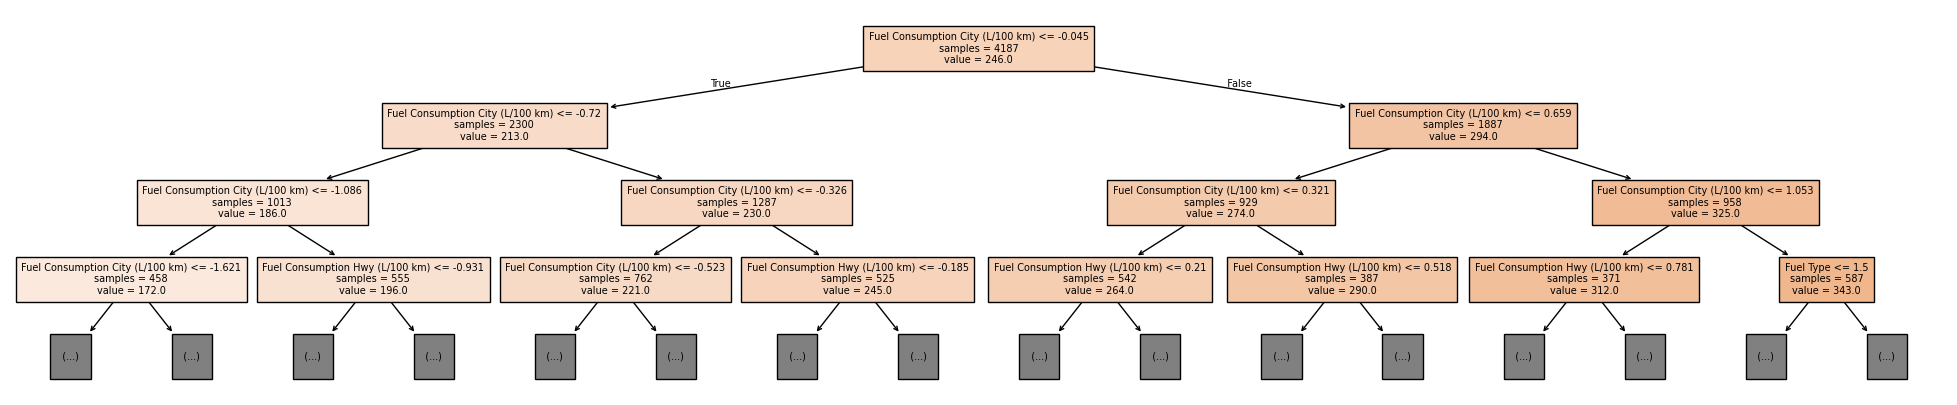

In [ ]:
print(pd.DataFrame(rt_model.feature_importances_, index=train_X.columns, columns=["Importance"]))

fig = plt.figure(figsize=(25,5))
_ = plot_tree(rt_model, max_depth=3, feature_names=train_X.columns,
              impurity=False, node_ids=False, filled=True, fontsize=7)

### XGBoost
XGBoost (Extreme Gradient Boosting) is an advanced machine learning algorithm that builds on gradient boosting to predict continuous or categorical outcomes. It constructs an ensemble of regression trees, where each tree corrects the errors of its predecessors by minimizing a loss function, typically through gradient descent. XGBoost splits data recursively based on feature values, optimizing a combination of loss and regularization terms to prevent overfitting. Its strength lies in handling non-linear relationships, scalability, and robustness to noisy or complex datasets.

The baseline XGBoost model showed slightly higher MSE compared to the Regression Tree model, indicating room for improvement. However, with an optimized hyperparameter configuration, XGBoost typically surpasses traditional machine learning models, delivering superior predictive performance.

In [ ]:
print("---- XGBOOST ----")
xgb_model = XGBRegressor(random_state=0, n_estimators=10).fit(train_X, train_y)
xgb_acc = get_error_measurements(train_set = train_set, test_set = test_set, fitted_model = xgb_model)

---- XGBOOST ----
R2 :	Train = 0.9963 		 Test = 0.9954
MSE:	Train = 12.9328 	 Test = 16.3689


In the next cell, **XGBoost model's hyperparameters were optimized** using 5-fold cross-validation on the training set to effectively balance bias and variance. Instead of exhaustive grid search or randomized search, a guided pursuit strategy was employed, optimizing parameters individually or in pairs following the methodology outlined in [XGBoost Parameters Tuning: A Complete Guide with Python Codes](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/). This targeted approach efficiently identifies optimal hyperparameter configurations, enhancing model performance while minimizing computational cost.

In [ ]:
# Hyperparameter tuning. First optimization: 'max_depth', 'min_child_weight'
_ = hyper_param_tuning(model = XGBRegressor(seed=123),
                       train_set = train_set,
                       param_grid = {'max_depth':range(1,15,1),
                                     'min_child_weight': [x/100.0 for x in range(0, 500, 50)]})

# Second optimization: 'gamma'
_ = hyper_param_tuning(model = XGBRegressor(max_depth=7, min_child_weight=0, seed=123),
                       train_set = train_set,
                       param_grid = {'gamma':[i/100.0 for i in range(0,50,5)]})

# Third optimization: 'subsample', 'colsample_bytree'
_ = hyper_param_tuning(model = XGBRegressor(max_depth=7, min_child_weight=0, gamma=0.15, seed=123),
                       train_set = train_set,
                       param_grid = {'subsample':[i/10.0 for i in range(1,10)],
                                     'colsample_bytree':[i/10.0 for i in range(1,10)]})

# Fourth optimization: 'reg_alpha'
_ = hyper_param_tuning(model = XGBRegressor(max_depth=7, min_child_weight=0, gamma=0.15,
                            subsample=0.8, colsample_bytree=0.9, seed=123), train_set = train_set,
                       param_grid = {'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 1, 100]})

Best hyper parameter configuration: {'max_depth': 7, 'min_child_weight': 0.0}
Best hyper parameter configuration: {'gamma': 0.15}
Best hyper parameter configuration: {'colsample_bytree': 0.9, 'subsample': 0.8}
Best hyper parameter configuration: {'reg_alpha': 0.2}


The final hyperparameter configuration (`max_depth=7, min_child_weight=0, gamma=0.15, subsample=0.8, colsample_bytree=0.9, reg_alpha=0.2`, along with `learning_rate=0.05, n_estimators=500`) was used to train an XGBoost model on the entire training set. The model's performance was then evaluated on a previously unseen test set, achieving superior $R^2$ and MSE scores compared to all previously tested models. The lesser difference between training and test MSEs indicates reduced overfitting. Diagnostic plots show no poorly predicted observations, confirming that the model delivers balanced and robust predictions.

In [ ]:
print("---- OPTIMIZED XGBOOST ----")
xgb_model = XGBRegressor(learning_rate=0.05, n_estimators=500,
                         max_depth=7, min_child_weight=0, gamma=0.15, subsample=0.8, colsample_bytree=0.9, reg_alpha=0.2, seed=123)
xgb_model.fit(train_X, train_y)
xgb_acc = get_error_measurements(train_set = train_set, test_set = test_set, fitted_model = xgb_model)

---- OPTIMIZED XGBOOST ----
R2 :	Train = 0.9993 		 Test = 0.9979
MSE:	Train = 2.4353 	 Test = 7.3564


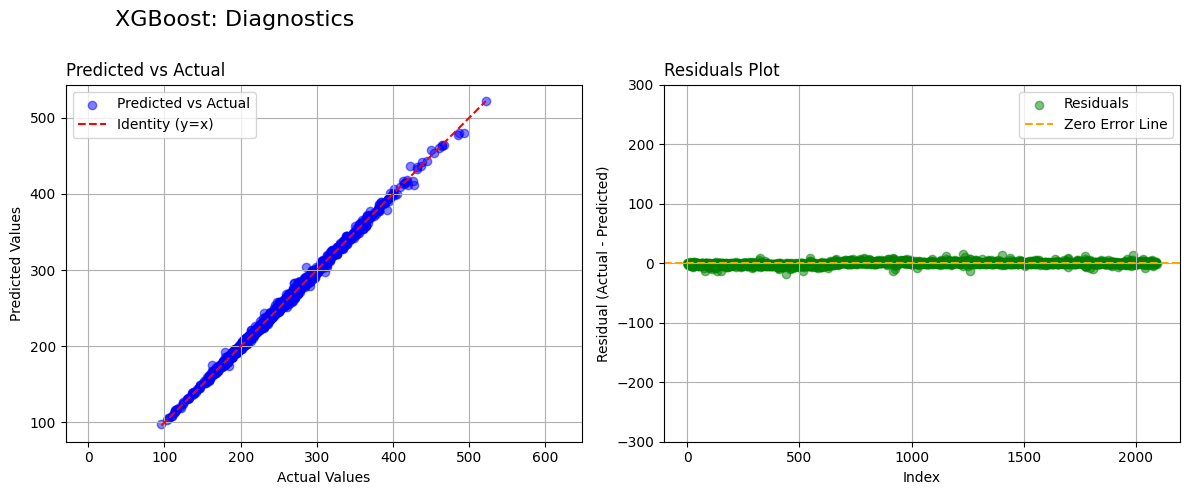

In [ ]:
plot_regression_diagnostics(test_y, xgb_model.predict(test_X),
                            fig_title="XGBoost: Diagnostics")

## Discussion and conclusion

In [ ]:
# Compilation of the results
model_names = ["Linear Regression", "Linear Regression (LASSO)", "SVM", "Regression Tree", "XGBoost"]
train_r2 = [reg_acc["Train-R2"][0], lasso_acc["Train-R2"][0], svm_acc["Train-R2"][0], rt_acc["Train-R2"][0], xgb_acc["Train-R2"][0]]
train_mse = [reg_acc["Train-MSE"][0], lasso_acc["Train-MSE"][0], svm_acc["Train-MSE"][0], rt_acc["Train-MSE"][0], xgb_acc["Train-MSE"][0]]
test_r2 = [reg_acc["Test-R2"][0], lasso_acc["Test-R2"][0], svm_acc["Test-R2"][0], rt_acc["Test-R2"][0], xgb_acc["Test-R2"][0]]
test_mse = [reg_acc["Test-MSE"][0], lasso_acc["Test-MSE"][0], svm_acc["Test-MSE"][0], rt_acc["Test-MSE"][0], xgb_acc["Test-MSE"][0]]
features = ["7", "5", "7", "7", "7"]

# Join the results in a single dataframe for easier comparison
ml_results = pd.DataFrame({"Model":model_names, "Features":features, "Train R2":train_r2,
                           "Test R2":test_r2, "Train MSE":train_mse, "Test MSE":test_mse})
ml_results

,Model,Features,Train R2,Test R2,Train MSE,Test MSE
0,Linear Regression,7,0.8927,0.8918,375.3010,384.3227
1,Linear Regression (LASSO),5,0.8818,0.8840,413.4137,412.1526
2,SVM,7,0.9048,0.9073,332.9549,329.1070
3,Regression Tree,7,0.9996,0.9962,1.3809,13.3340
4,XGBoost,7,0.9993,0.9979,2.4353,7.3564


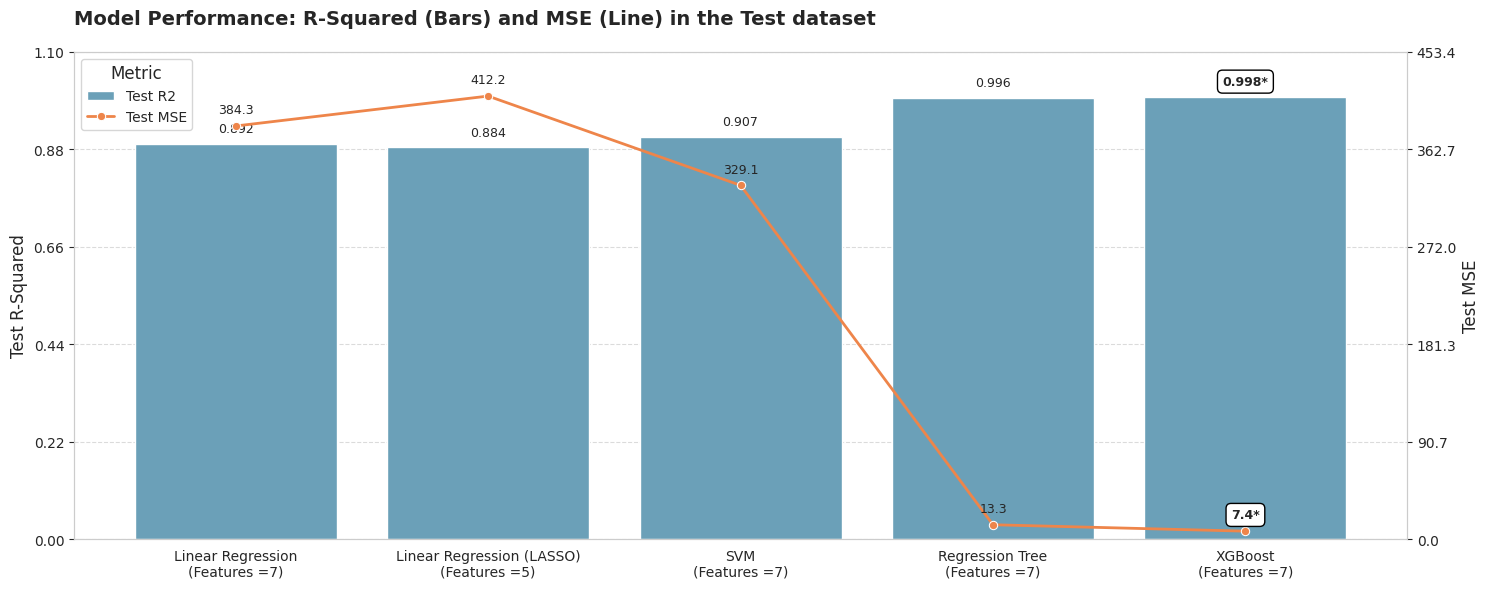

In [ ]:
plot_reg_results(ml_results, data_is_long=False)

This notebook developed regression models to predict CO2 emissions from vehicles using a preprocessed dataset of 6,281 rows and 7 features, including fuel consumption, engine size, cylinders, gears, fuel type, and transmission. Five models—Linear Regression, LASSO Regression, Support Vector Machine (SVM) with RBF kernel, Regression Trees and XGBoost—were evaluated to capture relationships between vehicle characteristics and emissions.

### Key Findings
1. **Model Performance**: XGBoost, with optimized hyperparameters, achieved the highest accuracy and generalization, outperforming SVM with RBF kernel, Linear Regression, LASSO Regression, and Regression Trees. The SVM with RBF kernel followed closely, offering a strong balance of accuracy and robustness.
2. **Feature Importance**: `Fuel Consumption City (L/100 km)` and `Fuel Consumption Hwy (L/100 km)` were the strongest predictors of CO2 emissions across models, while `Transmission` had minimal impact, as confirmed by linear model p-values and tree-based feature importance metrics.
3. **Model Insights**: XGBoost and SVM effectively captured non-linear patterns, with XGBoost showing minimal overfitting due to hyperparameter tuning (test MSE: 7.36 vs. train MSE: 2.43). Regression Trees, while highly accurate, exhibited slight overfitting (test MSE: 13.33 vs. train MSE: 1.38). Linear models confirmed a strong linear relationship but failed to capture some complex interactions.
4. **Dataset Limitations**: The dataset, covering Canadian vehicles from 2017–2021 with 6,281 rows and 7 features, may limit generalizability due to regional biases and the absence of features like vehicle weight or driving conditions, which could further enhance model accuracy.

### Future Work and Applications
- **Extend hyperparameter tuning**, already implemented for XGBoost, to SVM and Regression Trees using advanced methods like Bayesian optimization or randomized search to further optimize accuracy and reduce overfitting.
- **Additional features** could be incorporated, such as vehicle weight, driving patterns, and ambient temperature, to enhance the predictive power of models like XGBoost and SVM.
- **Dataset Expansion** to include data beyond the Canadian vehicles (2017–2021) to include diverse regions and time periods, improving generalizability for global applications.
- **Explore additional ensemble methods**, such as stacking XGBoost with SVM or Random Forests, to combine the strengths of individual models for improved performance and interpretability.
- **Applications**: environmental policies (profile of high-emission vehicle), automotive design (key fetures of eco-friendly vehicles), consumer tools (get sustainable purchasing decisions), among others.

In conclusion, this notebook successfully developed and evaluated five regression models to predict CO2 emissions from a dataset of Canadian vehicles (2017–2021). XGBoost, enhanced by hyperparameter tuning, emerged as the top performer, demonstrating exceptional accuracy and robustness in capturing complex relationships between vehicle characteristics and emissions. Despite limitations like regional biases and missing features, this work showcases proficiency in data preprocessing, model development, and performance evaluation, laying a strong foundation for future enhancements through advanced tuning, ensemble methods, and expanded datasets.